In [1]:
%matplotlib inline
import math
import random
random.seed(0)

import matplotlib.pyplot as plt
from IPython.display import Audio
import requests

API_URL = 'http://simphone.herokuapp.com/json'

# On-Off Keying (OOK) Modulation/Demodulation Demo

To pass a digital signal over a fake phone line, we need to modulate it. Phone lines are designed to just-barely carry speech by transmitting 300 to 3400 Hz signals. By reducing the bandwidth (frequency, not data) to where speech is just barely intelligible, phone companies can save ~~you~~ money!

Anyways, because the phone line doesn't pass baseband (DC) signals, we need to modulate the signal, i.e. turn it into sound. The laziest way to do so is to play a tone (be on) when there's a 1, and nothing (be off) when there's 0. This is on-off keying.

### Protocol Definition

Things that are known to both the modulator and demodulator so they can talk.

In [2]:
FS = 44100 # Hz, sample rate

BAUD = 100 # symbol rate
SYMBOLS = 2 # binary
FCARRIER = 800 # Hz

APPROX_TX_TIME = 3.9 # seconds
SYMBOLS_TO_TX = int(BAUD * APPROX_TX_TIME)
TX_TIME = SYMBOLS_TO_TX / BAUD # after rounding

### Some Data to Transmit

In [3]:
data = [random.randrange(SYMBOLS) for n in range(SYMBOLS_TO_TX)]
print(''.join(str(x) for x in data))

110111111001001010011011101110001011010000010011011010110110100001100000011001111101011000100101100000000001010000001000101000111001001011100000110100111111001010100111101110001000111011001010110011110100001110000000011001100110101001000011101111001100011110100100111010100100111110011110101101100100000010011110101010101000100111000000111001011111100011100101110000000101100111000101111000


## Modulating

In [4]:
t = list(n/FS for n in range(int(FS * TX_TIME)))
modulator = [data[int(tp * BAUD)] for tp in t]

carrier = [math.sin(2 * math.pi * FCARRIER * tp) for tp in t]

signal = [m * c for m, c in zip(modulator, carrier)]

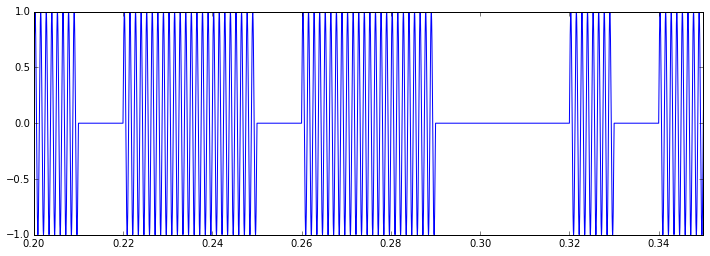

In [5]:
def pltsetup(bounds):
    f, ax = plt.subplots()
    f.set_size_inches((12, 4))
    ax.set_xlim(bounds)
    return f, ax

f, ax = pltsetup((0.2, 0.35))
ax.plot(t, signal)

In [6]:
print('Transmit file is {:.3f} seconds in length.'.format(len(signal) / FS))
Audio(signal, rate=FS)

Transmit file is 3.900 seconds in length.


## Processing

To filter and add noise to the audio, we'll pass it to the web API. We simply `POST` an object with a `data` key (and optional `seed` and `snr` attributes)

In [7]:
request = {
    'data': signal,
    'seed': 24601,
    'snr': 5, # default 30
}
reply = requests.post(API_URL, json=request).json()

In [8]:
received = reply['data']

In [9]:
Audio(received, rate=FS)

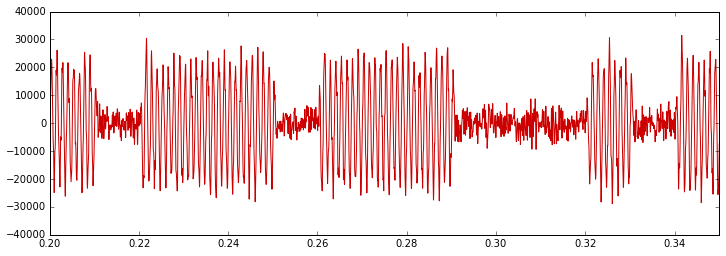

In [10]:
f, ax = pltsetup((0.2, 0.35))
ax.plot(t, received, color='#cc0000')

## Demodulating

There are myriad ways to demodulate signals, especially when using multiple frequencies. Here we take the lazy approach (circa 1900) and simply mix (multiply) the received signal with a similarly tuned carrier wave to recover something like the original signal.

In [11]:
# Mix carrier with signal
phase_offset = 2 * math.pi * random.random() # because an exact phase lock is kinda cheating
carrier = [math.sin(2 * math.pi * FCARRIER * tp + phase_offset) for tp in t]

demod = [r * c for r, c in zip(received, carrier)]

# Rectify
demod = [abs(d) for d in demod]

In [12]:
print(phase_offset)

4.654240640208287


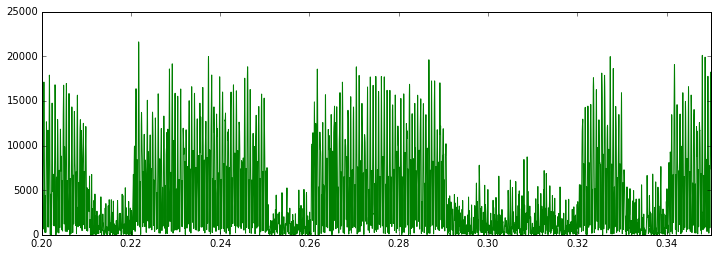

In [13]:
f, ax = pltsetup((0.2, 0.35))
ax.plot(t, demod, color='green')

In [14]:
# Sum the demodulated signal across the entire symbol duration (convolve) to be robust against noise
samples_per_symbol = FS/BAUD
symbol_starts = [s * samples_per_symbol for s in range(SYMBOLS_TO_TX)]

symbol_convolve = [sum(demod[int(s):int(s+samples_per_symbol)]) for s in symbol_starts]

In [15]:
# Threshold
conv50 = (max(symbol_convolve) + min(symbol_convolve)) / 2
output = [[0,1][s > conv50] for s in symbol_convolve]

In [16]:
print(''.join(str(x) for x in output))

110111111001001010011011101110001011010000010011011010110110100001100000011001111101011000100101100000000001010000001000101000111001001011100000110100111111001010100111101110001000111011001010110011110100001110000000011001100110101001000011101111001100011110100100111010100100111110011110101101100100000010011110101010101000100111000000111001011111100011100101110000000101100111000101111000


## Verification

This needs to be 100%.

In [17]:
print('Total:   {:5d}'.format(len(data)))
print('Correct: {:5d}'.format(sum(i == o for i, o in zip(data, output))))

Total:     390
Correct:   390
